In [1]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

## Unmod PWFS


In [2]:
wavelength = 800.0e-9
Dtel = 6.5
Dgrid = 60/56 * Dtel
n_bin = 2 #this allows us to oversample our pupil
grid = make_pupil_grid(60*n_bin, Dgrid) # could suepersample thi to stop aliasing errors
wfs_grid = make_pupil_grid(120*n_bin, 2 * Dgrid)

In [3]:
pwfs = PyramidWavefrontSensorOptics(grid, wfs_grid, separation=Dgrid, pupil_diameter=Dtel, wavelength_0=wavelength, q=4) # q gives pixels per lambda over D
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3 * wavelength/Dtel, num_steps=20) #, fast_modulation_method=True) # had to exlude bc not on sebastiaans version

In [4]:
aperture = evaluate_supersampled(make_magellan_aperture(), grid, 8) # anti aliasing filter => softens filter
wf = Wavefront(aperture, wavelength)
wf.total_power = 1.0

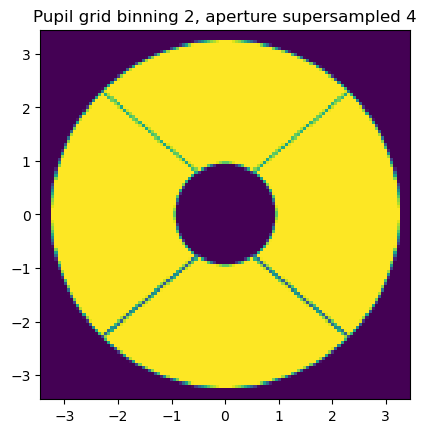

In [5]:
plt.figure()
plt.title(f"Pupil grid binning {n_bin}, aperture supersampled 4")
imshow_field(aperture)

In [6]:
# wanting to show the binning improvement




In [7]:
zmodes = make_zernike_basis(200, Dtel, grid, 2)
dm = DeformableMirror(zmodes)

In [8]:
ff = FourierFilter(grid, make_circular_aperture(2 * np.pi * 50 / Dtel), q=4)

## Make interaction matrix

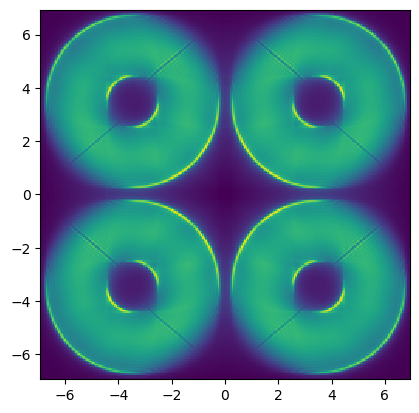

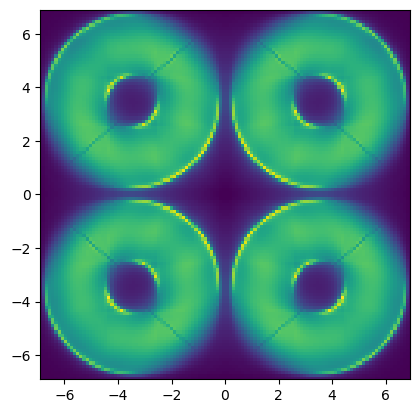

In [9]:
Iref = 0
for wfi in mpwfs(wf):
	Iref += wfi.power
Iref /= 20
Iref_bin = subsample_field(Iref, n_bin)
imshow_field(Iref)
plt.figure()
imshow_field(Iref_bin)

In [10]:
calibration_amplitude = 10e-9
dm.flatten()

slopes = []
for i in range(dm.num_actuators):
	if i % 10 == 0:
		print("Calibrating mode {:d}".format(i))

	slope = 0
	for s in [-1, 1]:
		dm.actuators[i] += s * calibration_amplitude

		im = 0		
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /=20
		im_binned = subsample_field(im, n_bin)

		slope += s * im_binned / (2 * calibration_amplitude)

		dm.actuators[i] -= s * calibration_amplitude
	slopes.append(slope)
slopes = np.array(slopes).T
reconstruction_matrix = inverse_tikhonov(slopes,1e-3)

Calibrating mode 0
Calibrating mode 10
Calibrating mode 20
Calibrating mode 30
Calibrating mode 40
Calibrating mode 50
Calibrating mode 60
Calibrating mode 70
Calibrating mode 80
Calibrating mode 90
Calibrating mode 100
Calibrating mode 110
Calibrating mode 120
Calibrating mode 130
Calibrating mode 140
Calibrating mode 150
Calibrating mode 160
Calibrating mode 170
Calibrating mode 180
Calibrating mode 190


In [11]:
mode_index = np.array([0, 41 , 181])
amplitudes = np.linspace(0, 400e-9, 20)

In [17]:
num_iterations = 3
coef = np.zeros((mode_index.size, amplitudes.size, num_iterations))
wfe_res = 40e-9

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = amp

			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
			sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
			sa.surface_sag *= wfe_res / np.std(sa.surface_sag[aperture>0])

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in mpwfs(sa(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)

			#coef[k, ai, i] = reconstruction_matrix.dot( im - Iref )[mi]
			#direct reconstructions:
			coef[k, ai, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2


/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [18]:
dl_coef = np.zeros((mode_index.size, amplitudes.size))
for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		dm.flatten()
		dm.actuators[mi] = amp

		im = 0
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#recondstruction matrix
		#dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
		#direct reconstruction:
		dl_coef[k, ai] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

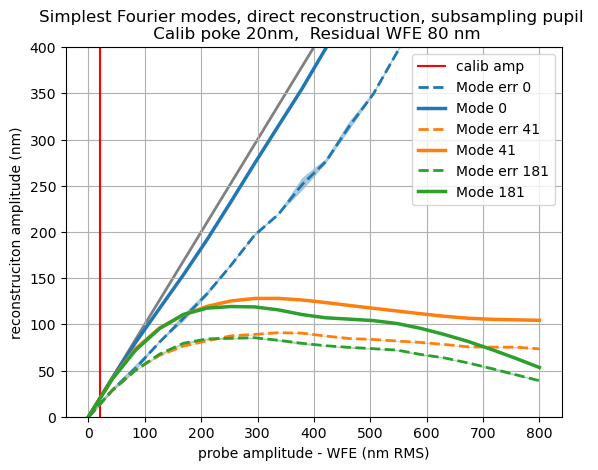

In [19]:
plt.axvline(2*calibration_amplitude/1e-9, label = 'calib amp', color = 'red')
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
for i in range(3):
	mean = 2*np.mean(coef, axis=2)[i] / 1e-9
	std = 2*np.std(coef, axis=2)[i] / 1e-9
	# dashed: average mode with errors
	plt.fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label='Mode err {:d}'.format(mode_index[i]))
	# solid: default
	plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
plt.title(f"Simplest Fourier modes, direct reconstruction, subsampling pupil \n Calib poke {(2*calibration_amplitude/1e-9):0.0f}nm,  Residual WFE {(2*wfe_res/1e-9):0.0f} nm")
plt.xlabel("probe amplitude - WFE (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.ylim([0,400])
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_143228/425262016.py:8: RuntimeWarning: divide by zero encountered in divide
  gain =  mean / (2*dl_coef[i, :])
/tmp/ipykernel_143228/425262016.py:9: RuntimeWarning: divide by zero encountered in divide
  gain_std = std / (2*dl_coef[i, :])
/tmp/ipykernel_143228/425262016.py:11: RuntimeWarning: invalid value encountered in add
  plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)


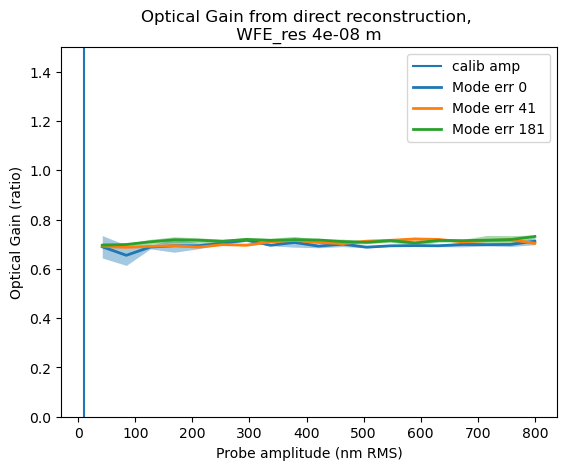

In [20]:
# optical gain by ratio
plt.axvline(calibration_amplitude/1e-9, label = 'calib amp')

for i in range(3):
	amps = 2*amplitudes/1e-9 # in WFE units, not DM surface
	mean = 2*np.mean(coef, axis=2)[i] 
	std = 2*np.std(coef, axis=2)[i]
	gain =  mean / (2*dl_coef[i, :])
	gain_std = std / (2*dl_coef[i, :])
	# dashed: average mode with errors
	plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amps, gain, lw=2, color='C{:d}'.format(i),  label='Mode err {:d}'.format(mode_index[i]))
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
plt.title(f"Optical Gain from direct reconstruction, \n WFE_res {wfe_res} m ")
plt.xlabel("Probe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.ylim([0, 1.5])
plt.legend()
plt.show()

## iterate over the residual WFE

In [24]:
# optical gain by residual
num_iterations = 10
residuals = np.linspace(0, 200e-9, 25)
WFE_coef = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
			sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
			sa.surface_sag *= res / np.std(sa.surface_sag[aperture>0]) # in wfe??

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in mpwfs(sa(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			WFE_coef[k, ri, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [25]:
# calculate streh
residuals_wfe = 2*residuals
strehl = np.exp(-(2*np.pi*residuals_wfe/wavelength)**2)

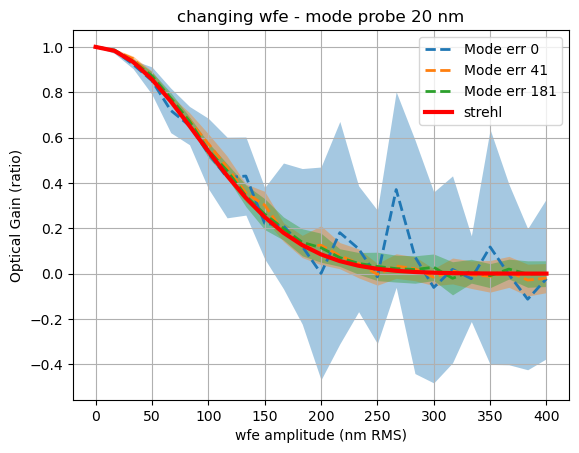

In [32]:
for i in range(3):
	mean = np.mean(WFE_coef, axis=2)[i] 
	std = np.std(WFE_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	plt.fill_between(residuals_wfe/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(residuals_wfe/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label='Mode err {:d}'.format(mode_index[i]))
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
#plt.plot(residuals/1e-9, residuals/1e-9, color='gray', zorder=-1, lw=2)
plt.plot(residuals_wfe/1e-9, strehl, color = 'red', label='strehl', lw = 3)
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel("wfe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# could replot with OG vs. strehl  > line